In [2]:
#!!! Uncomment this block if you are on colab!
# %pip install rdkit-pypi -qqq
# %pip install deepchem -qqq
# #%pip install dgl==0.9 -qqq
# #%pip install dgllife -qqq
# %pip install tensorflow -qqq
# %pip install torch -qqq
#
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Colab Notebooks/MDRinhib

In [1]:
import deepchem as dc
import dgl
import torch
import pandas as pd
import numpy as np
from deepchem.models import AttentiveFP
from deepchem.models import AttentiveFPModel
from deepchem.models import DTNNModel
from deepchem.models import GraphConvModel
from deepchem.feat import MolGraphConvFeaturizer

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_sparse'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (c:\Users\xsj110\AppData\Local\Programs\Python\Python38\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jaxlib'


In [2]:
# Tests
smiles = ["C1CCC1", "C1=CC=CN=C1"]
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
graphs = featurizer.featurize(smiles)
print(type(graphs[0]))
dgl_graphs = [graphs[i].to_dgl_graph(self_loop=True) for i in range(len(graphs))]
batch_dgl_graph = dgl.batch(dgl_graphs)
model = AttentiveFP(n_tasks=1, mode='regression')
preds = model(batch_dgl_graph)
print(type(preds))

<class 'deepchem.feat.graph_data.GraphData'>
<class 'torch.Tensor'>


In [3]:
smiles = ["C1CCC1", "C1=CC=CN=C1", "CCC"]
labels = [0., 1., 0.]
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
X = featurizer.featurize(smiles)
dataset = dc.data.NumpyDataset(X=X, y=labels)
model = AttentiveFPModel(mode='classification', n_tasks=1, batch_size=16, learning_rate=0.001)
loss = model.fit(dataset, nb_epoch=5)
loss

0.09641736149787902

In [4]:
# Read sdf file with structures
input_structures_file = Chem.SDMolSupplier('All_input_structures.sdf')
structures = []

# Append strutures to a list
for x in input_structures_file:
    y = Chem.Mol(x)
    AllChem.Compute2DCoords(y)
    structures.append(y)

print(len(structures))

1116


c:\Users\xsj110\AppData\Local\Programs\Python\Python38\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 4. Change the maxMols value to display more.
  warnings.warn(


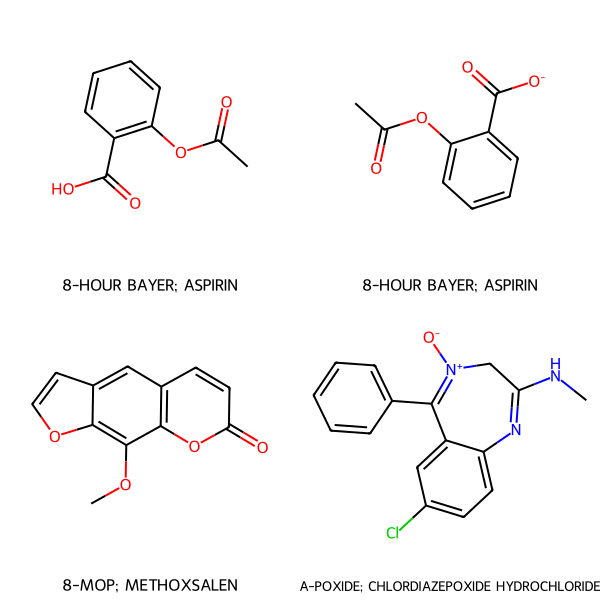

In [5]:
Draw.MolsToGridImage(
    structures,
    molsPerRow=2,
    maxMols=4,
    subImgSize=(300, 300), 
    legends=[x.GetProp("FDA drugnames") for x in structures]
    )

# Data import

In [7]:
# This function takes a list of structures that was docked in different conformations
# (ie. the same structure occurs several times) and returns a unique list of structures
def unique_ligands(list_of_structures):
    
    unique_list_prop = []
    unique_list = []

    for x in list_of_structures:
        test = x.GetProp("FDA drugnames") + x.GetProp('s_i_glide_gridfile')
        if test not in unique_list_prop:
            unique_list_prop.append(test)
            unique_list.append(x)
    return unique_list

# Read sdf file with ligands docked to protein
suppl = Chem.SDMolSupplier('All_proteins_total.sdf')

# Put each ligand into list
mols_docked = [x for x in suppl]
print("Total number of FDA drug conformations successfully docked: " + str(len(mols_docked)))

unique_mols_docked = unique_ligands(mols_docked)
print("Number of FDA drugs successfully docked: " + str(len(unique_mols_docked)))

Total number of FDA drug conformations successfully docked: 30861
Number of FDA drugs successfully docked: 10151


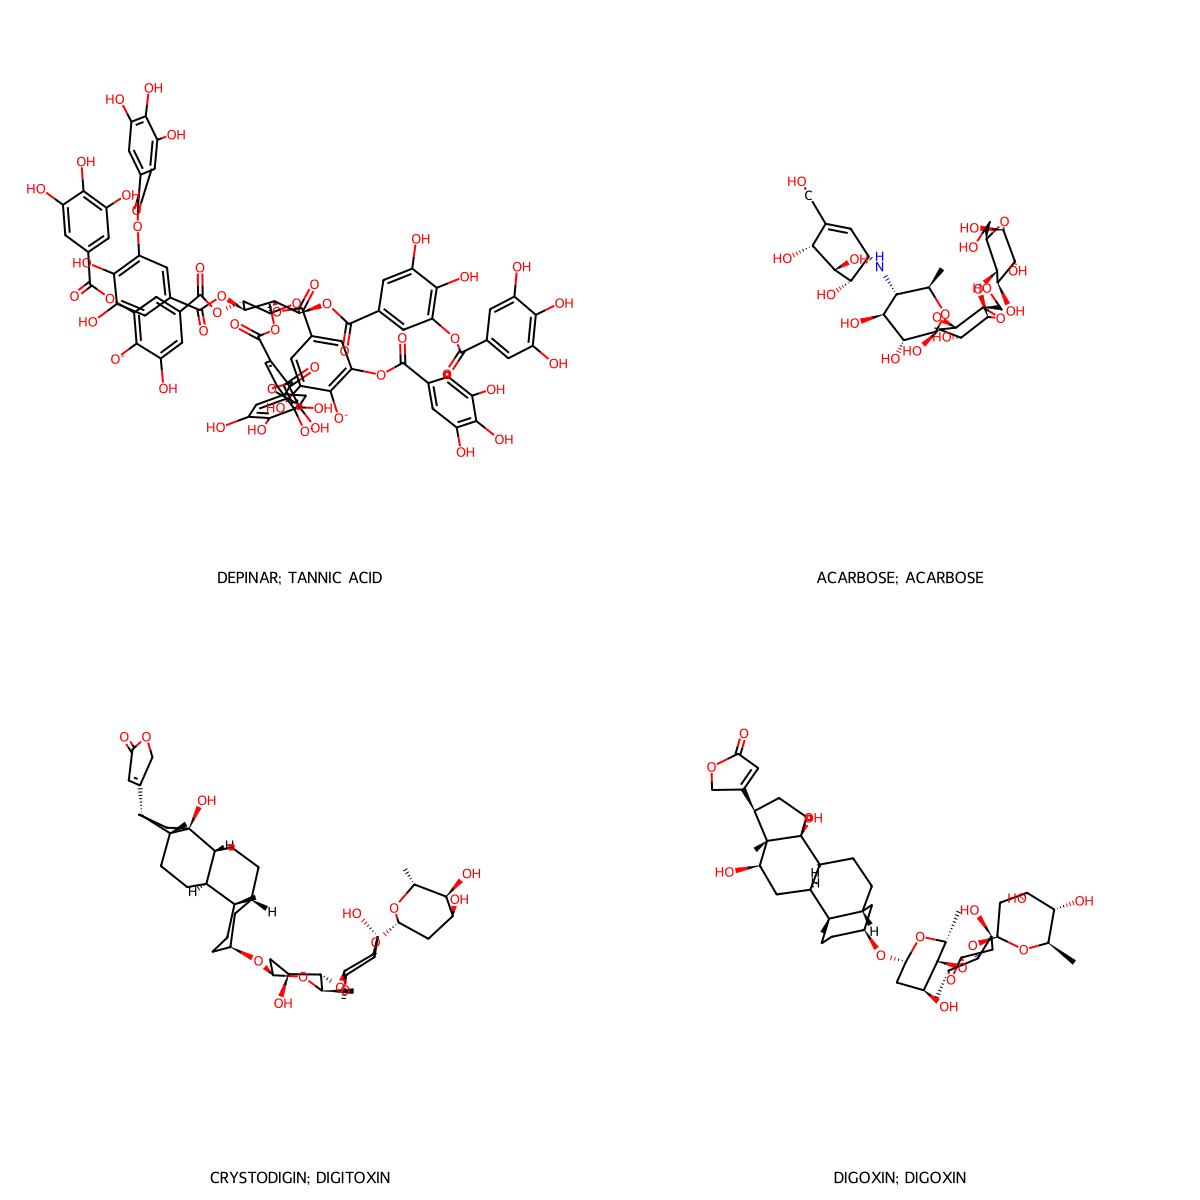

In [9]:
Draw.MolsToGridImage(
    unique_mols_docked,
    molsPerRow=2,
    maxMols=4,
    subImgSize=(600, 600),
    legends=[x.GetProp("FDA drugnames") for x in unique_mols_docked]
    )

In [14]:
mollist = [] # list of uniquely docked mol objects for featurization

# Creates a list of lists with information on
# Transporter name and site
# Molecule name
# Docking score
for mol in unique_mols_docked:
    mollist.append([mol.GetProp('s_i_glide_gridfile'), mol.GetProp('FDA drugnames'), float(mol.GetProp('r_i_glide_gscore')), mol])

print(mollist[0])
print(mollist[10000])

df = pd.DataFrame.from_records(mollist)
df = df.pivot(index=1, columns=0, values=[2,3])

receptors = []

# The following code fetches receptor names and lists them to be applied as columns in the dataFrame
for rec in df.keys():
    receptors.append(rec[1][11:15])

no_receptors = int(len(receptors)/2)
receptor_scores = []

for i in range(len(receptors)):
    if i >= no_receptors:
        receptors[i] = receptors[i] + "_mol"
    else:
        receptor_scores.append(receptors[i])

df.columns = receptors

# Rounds numbers in the dataFrame to 1 decimal
for rec in receptor_scores:
    df[rec] = pd.to_numeric(df[rec]).round(1)

# Replaces Nan values with 0
df = df.fillna(0)

# Export mol objects
docked_mols = df['MRP8_mol'].values.tolist()
# Use 551 from MRP2 instead of MRP8 as it is missing from the MRP8 list of objects
docked_mols[551] = df[('MRP2_mol')][551]

# Get docking scores and store in np array
y_values = np.array(df.iloc[0:, :no_receptors], dtype=np.float64)

df_scores = df.iloc[0:, :no_receptors]
#df_scores.to_excel("docking_scores.xlsx")


['glide-grid_MRP1_site_1', 'DEPINAR; TANNIC ACID', -24.1806681857067, <rdkit.Chem.rdchem.Mol object at 0x0000021B4AA4CAC0>]
['glide-grid_BCRP_site_4', 'ATROPINE AND DEMEROL; MEPERIDINE HYDROCHLORIDE', -4.51580396809298, <rdkit.Chem.rdchem.Mol object at 0x0000021BE314CCF0>]


In [16]:
df

,BCRP,MDR1,MRP1,MRP2,MRP3,MRP4,MRP5,MRP6,MRP7,MRP8,...,MDR1_mol,MRP1_mol,MRP2_mol,MRP3_mol,MRP4_mol,MRP5_mol,MRP6_mol,MRP7_mol,MRP8_mol,MRP9_mol
1,,,,,,,,,,,,,,,,,,,,,
8-HOUR BAYER; ASPIRIN,-5.3,-6.4,-5.1,-4.9,-4.1,-5.1,-9.3,-4.1,-3.5,-4.2,...,<rdkit.Chem.rdchem.Mol object at 0x0000021BCB5...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AA...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AA...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B871...,<rdkit.Chem.rdchem.Mol object at 0x0000021BA3C...,<rdkit.Chem.rdchem.Mol object at 0x0000021BB19...,<rdkit.Chem.rdchem.Mol object at 0x0000021BBC7...
8-MOP; METHOXSALEN,-8.0,-6.4,-4.8,-3.9,-4.7,-4.7,-3.8,-3.9,-4.7,-5.7,...,<rdkit.Chem.rdchem.Mol object at 0x0000021BCB5...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AA...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AA...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B870...,<rdkit.Chem.rdchem.Mol object at 0x0000021B871...,<rdkit.Chem.rdchem.Mol object at 0x0000021B94E...,<rdkit.Chem.rdchem.Mol object at 0x0000021BB19...,<rdkit.Chem.rdchem.Mol object at 0x0000021BBC8...
A-POXIDE; CHLORDIAZEPOXIDE HYDROCHLORIDE,-10.1,-10.7,-7.9,-6.9,-7.9,-6.9,-8.5,-6.2,-4.4,-9.7,...,<rdkit.Chem.rdchem.Mol object at 0x0000021BCB5...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AA...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AA...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B871...,<rdkit.Chem.rdchem.Mol object at 0x0000021BA3C...,<rdkit.Chem.rdchem.Mol object at 0x0000021BA3C...,<rdkit.Chem.rdchem.Mol object at 0x0000021BBC7...
ABACAVIR AND LAMIVUDINE; LAMIVUDINE,-7.1,-6.3,-5.9,-6.7,-5.0,-5.0,-7.4,-5.6,-5.2,-4.6,...,<rdkit.Chem.rdchem.Mol object at 0x0000021BCB5...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AA...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AA...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B871...,<rdkit.Chem.rdchem.Mol object at 0x0000021B94E...,<rdkit.Chem.rdchem.Mol object at 0x0000021BB19...,<rdkit.Chem.rdchem.Mol object at 0x0000021BBC7...
"ABACAVIR SULFATE, LAMIVUDINE AND ZIDOVUDINE; ZIDOVUDINE",-6.8,-7.6,-5.5,-4.6,-5.3,-5.1,-6.6,-4.4,-5.0,-3.8,...,<rdkit.Chem.rdchem.Mol object at 0x0000021BCB5...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AA...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AA...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B871...,<rdkit.Chem.rdchem.Mol object at 0x0000021B94E...,<rdkit.Chem.rdchem.Mol object at 0x0000021BB19...,<rdkit.Chem.rdchem.Mol object at 0x0000021BBC7...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZONTIVITY; VORAPAXAR SULFATE,-10.1,-8.6,-5.2,-5.8,-5.9,-6.9,-7.5,-3.2,-3.9,-5.8,...,<rdkit.Chem.rdchem.Mol object at 0x0000021BCB5...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AA...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AA...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AB...,<rdkit.Chem.rdchem.Mol object at 0x0000021B94E...,<rdkit.Chem.rdchem.Mol object at 0x0000021BA3C...,<rdkit.Chem.rdchem.Mol object at 0x0000021BB19...,<rdkit.Chem.rdchem.Mol object at 0x0000021BBC7...
ZYDELIG; IDELALISIB,-9.3,-8.5,-6.4,-5.2,-6.1,-8.2,-7.2,-6.0,-5.4,-6.3,...,<rdkit.Chem.rdchem.Mol object at 0x0000021BCB5...,<rdkit.Chem.rdchem.Mol object at 0x0000021B4AA...,<rdkit.Chem.rdchem.Mol object at 0x000

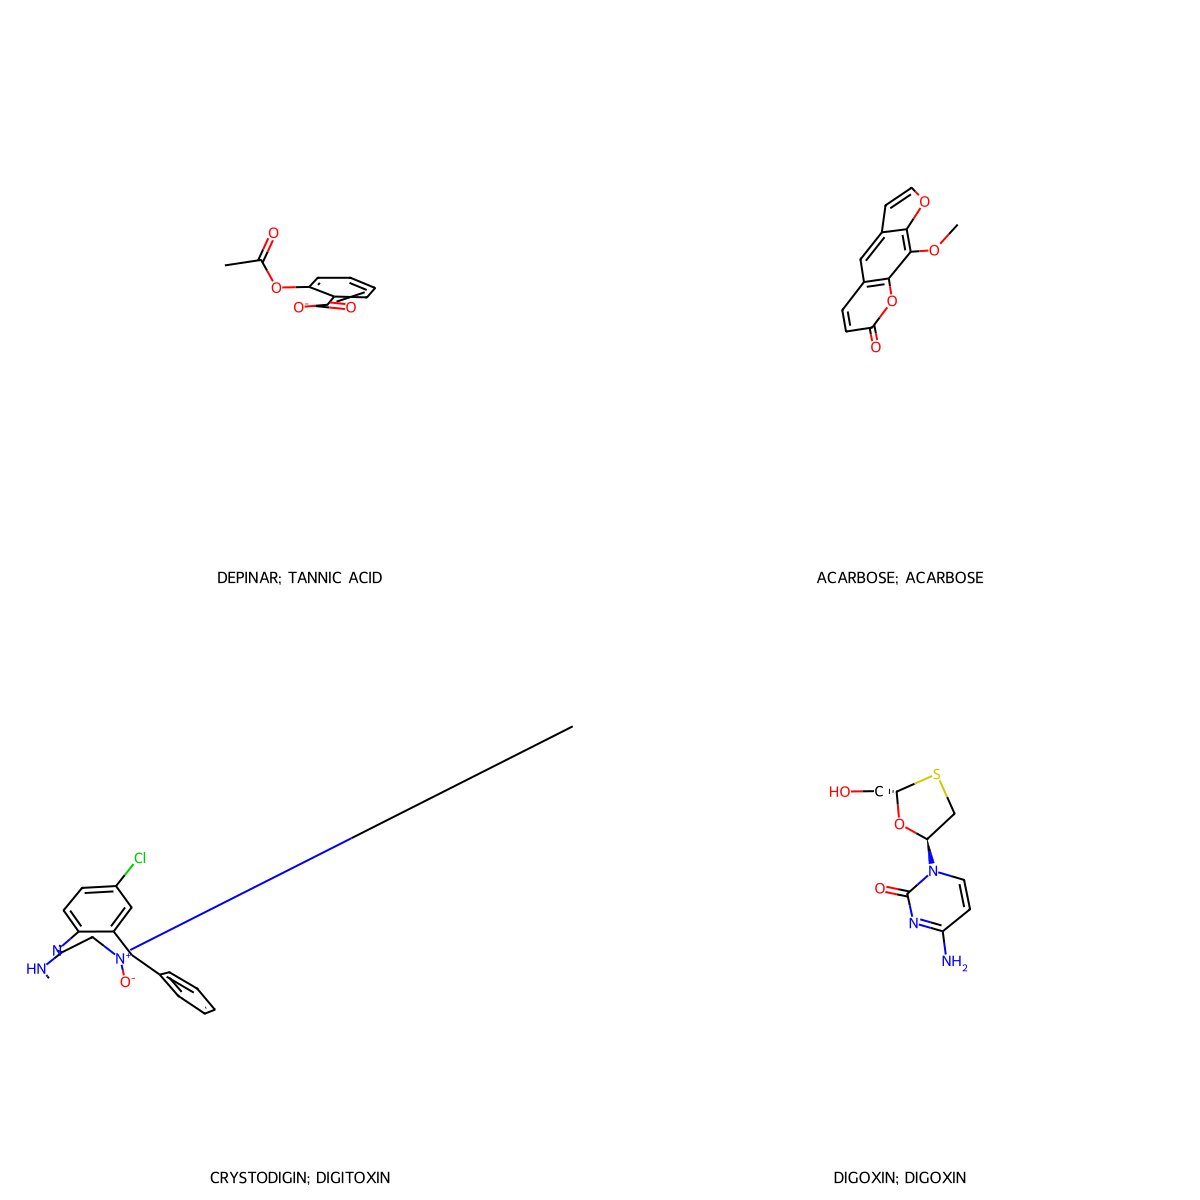

In [22]:
Draw.MolsToGridImage(
    df.iloc[0:5,16],
    molsPerRow=2,
    maxMols=4,
    subImgSize=(600, 600),
    legends=[x.GetProp("FDA drugnames") for x in unique_mols_docked]
)

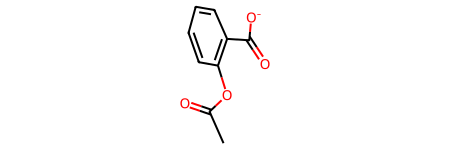

In [12]:
df.loc[:,'MRP1_mol'][0]

In [13]:
# Draw.MolsToGridImage(
#     docked_mols,
#     molsPerRow=2,
#     maxMols=4,
#     subImgSize=(300, 300),
#     legends=[x.GetProp("FDA drugnames") for x in docked_mols]
#     )

# Data analysis

In [14]:
# Show the docked molecules for each receptor

best = []

for col in receptor_scores:
    column = df[col]
    min_value = column.min()
    min_index = column.idxmin()
    best.append([col, min_index, min_index])

df_best = pd.DataFrame(best)
df_best.columns = ["Receptor", "Drug", "Docking score"]
df_best

,Receptor,Drug,Docking score
0,BCRP,SYNAREL; NAFARELIN ACETATE,SYNAREL; NAFARELIN ACETATE
1,MDR1,DEPINAR; TANNIC ACID,DEPINAR; TANNIC ACID
2,MRP1,DEPINAR; TANNIC ACID,DEPINAR; TANNIC ACID
3,MRP2,DEPINAR; TANNIC ACID,DEPINAR; TANNIC ACID
4,MRP3,DEPINAR; TANNIC ACID,DEPINAR; TANNIC ACID
5,MRP4,DEPINAR; TANNIC ACID,DEPINAR; TANNIC ACID
6,MRP5,DEPINAR; TANNIC ACID,DEPINAR; TANNIC ACID
7,MRP6,DEPINAR; TANNIC ACID,DEPINAR; TANNIC ACID
8,MRP7,DEPINAR; TANNIC ACID,DEPINAR; TANNIC ACID
9,MRP8,DEPINAR; TANNIC ACID,DEPINAR; TANNIC ACID


In [15]:
# Set threshold docking score for analysis and create dataframe with these

def _color_red_or_green(val):
    color = 'red' if val > -14 else 'green'
    return 'color: %s' % color

min_score = -14

df_highscore = df[(df_scores < min_score).any(1)]
df_highscore.fillna(0)

d = dict.fromkeys(df.select_dtypes('float').columns, "{:,.1f}")
df3 = df_highscore.iloc[0:, :no_receptors].style.applymap(_color_red_or_green).format(d)

# Extract molecules with docking score better than min_score to a list for plotting

list_min_score = []

for i, row in df_highscore.iterrows():
    for j, col in row.iteritems():
        if isinstance(col, float):
            if col < min_score:
                list_min_score.append(df_highscore.loc[i].at[str(j) + "_mol"])
df3

C:\Users\xsj110\AppData\Local\Temp\ipykernel_11176\2061164350.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  df_highscore = df[(df_scores < min_score).any(1)]
C:\Users\xsj110\AppData\Local\Temp\ipykernel_11176\2061164350.py:20: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for j, col in row.iteritems():


,BCRP,MDR1,MRP1,MRP2,MRP3,MRP4,MRP5,MRP6,MRP7,MRP8,MRP9
1,,,,,,,,,,,
ACARBOSE; ACARBOSE,-14.4,-13.8,-16.2,-13.2,-14.1,-14.7,-13.1,-13.9,-13.5,-11.3,-12.9
CROLOM; CROMOLYN SODIUM,-10.0,-11.0,-8.7,-7.5,-6.9,-9.6,-14.8,-4.3,-3.5,-4.3,-9.2
DEPINAR; TANNIC ACID,0.0,-24.0,-24.2,-26.1,-25.9,-21.5,-27.4,-21.6,-19.0,-22.2,0.0
KENGREAL; CANGRELOR,-11.3,-11.4,-9.8,-10.0,-8.9,-12.0,-14.7,-9.3,-7.8,-9.9,-14.5
KINEVAC; SINCALIDE,-11.8,-9.6,-9.3,-9.9,-9.4,-10.9,-17.9,-8.7,-8.3,-12.6,-8.8
OTREXUP; METHOTREXATE,-7.9,-9.5,-7.9,-7.6,-8.0,-9.0,-14.1,-6.8,-8.4,-6.6,-9.1
PEPTAVLON; PENTAGASTRIN,-11.7,-11.0,-10.5,-12.9,-12.1,-11.4,-16.4,-10.4,-10.4,-11.0,-12.9
SYNAREL; NAFARELIN ACETATE,-15.6,-9.1,-10.6,-10.6,-12.1,-13.6,-9.7,-9.5,-12.2,-14.8,-7.8


In [16]:
pltmol = []

for x in list_min_score:
    y = Chem.Mol(x)
    AllChem.Compute2DCoords(y)
    pltmol.append(y)

# Draw.MolsToGridImage(
#     pltmol,
#     molsPerRow=2,
#     #maxMols=10,
#     subImgSize=(500, 500),
#     legends=[x.GetProp("FDA drugnames") + " | score: " + str(x.GetProp('r_i_glide_gscore')[:4])  + "\n\n" + x.GetProp('s_i_glide_gridfile') for x in pltmol]
# )

In [17]:
y = y_values[:,0]

In [18]:
y

array([ -5.3,  -8. , -10.1,  -7.1,  -6.8,  -6.3,  -9.1,  -8.3,  -8.3,
        -8.1, -14.4,  -8.6,  -4.8,  -8.5,  -5.5,  -5.4,  -5.1,  -4.2,
        -3.8,  -4.8,  -4.2,  -3.1,  -5.8,  -6. ,  -2.3,  -6.5,  -6.6,
       -11.6,  -5.9,  -9.9,  -8.9,  -4.8,  -5. ,  -9.3,  -6.3,  -5.2,
       -12. ,  -8.8,  -1.9, -10.6,  -8.7,  -6.2,  -6.1,  -5.6, -10.4,
        -5. ,  -7.8,  -2.5,  -4.6,  -7.2,  -4.8,  -7.4,  -9.7,  -5.2,
        -4.6,  -8.1,  -8.6,  -3.6,  -3.5,  -5.1,  -7.7,  -6.7,  -6.9,
        -4.9,  -9.1,  -6.1, -10.4,  -6.5,  -6.9,   0. ,  -7.5,  -7.4,
        -6. ,  -7.7,  -6.5,  -5.4,  -7.2,  -7.8,  -7.4,  -8.1,  -4.6,
        -7.7,  -5.9,  -6.3,  -5.6,  -5.4,  -5.7,  -4.8, -10.5,  -6. ,
        -6.2,  -6.2,  -6.2, -10.4,  -4.7,  -5.8,  -2.8,  -6.4,  -5. ,
        -6. ,  -9.5,  -5.1,  -7.3,  -7.4,  -7.4,   0. ,  -7.9,  -7.7,
        -6.6,  -4.2,  -7.2,  -2.6,  -7.6,  -4.9,  -1.3,  -5. ,  -8.2,
        -5.3,  -7.4,  -8.7,  -2.6,  -5.8,  -9.6, -12.8,  -7.4,  -7.8,
        -4.9,  -5. ,

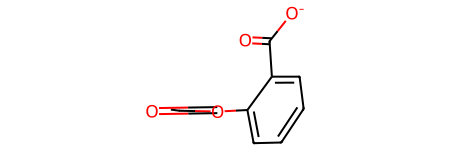

In [19]:
docked_mols[0]

In [125]:
featurizer = MolGraphConvFeaturizer(use_edges=True)

x = featurizer.featurize(docked_mols)

In [126]:
# Create dataset for deepchem
dataset = dc.data.NumpyDataset(X=x, y=y)

In [127]:
# Split dataset into train, validation and test datasets
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset = dataset,
    frac_train = 0.8,
    frac_valid = 0.1,
    frac_test = 0.1
)

len(test_dataset)



92

In [128]:
o_receptors = 11 # Should be extracted from sd dataset. ToDo
# training model
model = AttentiveFPModel(mode='regression', n_tasks=1, batch_size=16, learning_rate=0.001, dropout=0.01)

# loss = model.fit(train_dataset, nb_epoch=1)
# loss

8.984477167544158

In [24]:
metric = dc.metrics.Metric(dc.metrics.r2_score)
print('Training set score:', model.evaluate(train_dataset, [metric]))
print('Test set score:', model.evaluate(test_dataset, [metric]))
print('Validation set score:', model.evaluate(valid_dataset, [metric]))

Training set score: {'r2_score': -8.467946850196629}
Test set score: {'r2_score': -7.883829388071934}
Validation set score: {'r2_score': -7.358276977688256}


In [25]:
# predict from smiles string
X_predict = featurizer.featurize("CCCCCC")
dataset_predict = dc.data.NumpyDataset(X=X_predict)
model.predict(dataset_predict)

array([[-0.0252005]], dtype=float32)

Lets try an ordinary graph convolutional model

In [141]:
df_BCRP =  df[['BCRP', 'BCRP_mol']]
df_BCRP
mask = df_BCRP['BCRP_mol'] == 0
df_BCRP = df_BCRP.drop(df[mask].index)
df_BCRP

,BCRP,BCRP_mol
1,,
8-HOUR BAYER; ASPIRIN,-5.3,<rdkit.Chem.rdchem.Mol object at 0x0000024F5C7...
8-MOP; METHOXSALEN,-8.0,<rdkit.Chem.rdchem.Mol object at 0x0000024F5C7...
A-POXIDE; CHLORDIAZEPOXIDE HYDROCHLORIDE,-10.1,<rdkit.Chem.rdchem.Mol object at 0x0000024F5C7...
ABACAVIR AND LAMIVUDINE; LAMIVUDINE,-7.1,<rdkit.Chem.rdchem.Mol object at 0x0000024F5C7...
"ABACAVIR SULFATE, LAMIVUDINE AND ZIDOVUDINE; ZIDOVUDINE",-6.8,<rdkit.Chem.rdchem.Mol object at 0x0000024F5C7...
...,...,...
ZONTIVITY; VORAPAXAR SULFATE,-10.1,<rdkit.Chem.rdchem.Mol object at 0x0000024F5C7...
ZYDELIG; IDELALISIB,-9.3,<rdkit.Chem.rdchem.Mol object at 0x0000024F5C7...
ZYFLO CR; ZILEUTON,-7.4,<rdkit.Chem.rdchem.Mol object at 0x0000024F5C7...


In [142]:
feat = dc.feat.ConvMolFeaturizer()
x = feat.featurize(df_BCRP['BCRP_mol'])
y = df_BCRP['BCRP']

In [143]:
# Create dataset for deepchem
dataset = dc.data.NumpyDataset(X=x, y=y)

# Split dataset into train, validation and test datasets
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset = dataset,
    frac_train = 0.8,
    frac_valid = 0.1,
    frac_test = 0.1,
    seed=2,
)

len(test_dataset)

92

In [169]:
# Fit models
metric = dc.metrics.Metric(dc.metrics.rms_score)

# Do setup required for tf/keras models
# Number of features on conv-mols
n_feat = 75
# Batch size of models
batch_size = 32
model = GraphConvModel(1, batch_size=batch_size, mode='regression', number_atom_features=n_feat)

In [182]:
model.fit(train_dataset, nb_epoch=100)

0.18648285865783693

In [183]:
print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric])
valid_scores = model.evaluate(valid_dataset, [metric])
test_scores = model.evaluate(test_dataset, [metric])

print("Train scores")
print(train_scores, "\n")

print("Validation scores")
print(valid_scores, "\n")

print("Validation scores")
print(test_scores, "\n")


Evaluating model
Train scores
{'rms_score': 0.35351500754724535} 

Validation scores
{'rms_score': 1.5319950026453635} 

Validation scores
{'rms_score': 1.5429144229298712} 



In [184]:
train_preds = model.predict(train_dataset)
test_preds = model.predict(test_dataset)

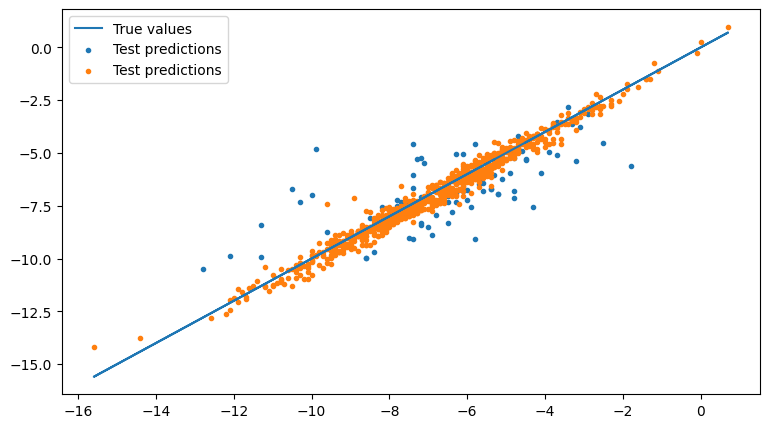

In [185]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.plot(dataset.y, dataset.y, label='True values')
plt.scatter(test_dataset.y, test_preds, marker='.', label='Test predictions')
plt.scatter(train_dataset.y, train_preds, marker='.', label='Test predictions')

plt.legend()
